# IELTS Essay Scoring Model Evaluation

This notebook evaluates and calibrates our IELTS essay scoring model, analysing its performance and generating insights for the research paper.

## Key Objectives:
1. Calibrate model predictions to valid IELTS band range (0-9)
2. Calculate model accuracy metrics (MAE, R²)
3. Visualise prediction performance

MAE: 0.289
R^2: 0.843
Pearson r: 0.925
Spearman rho: 0.925


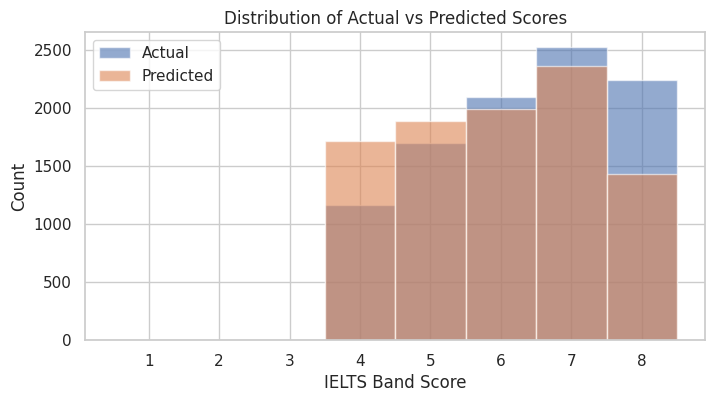

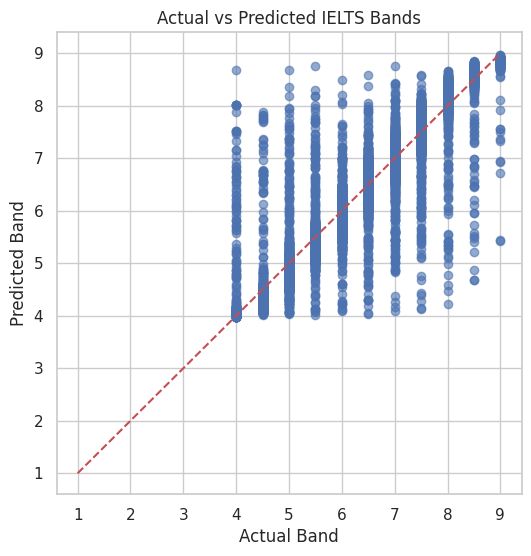

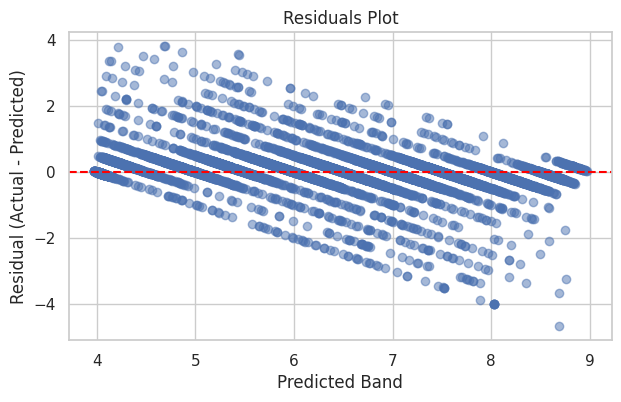

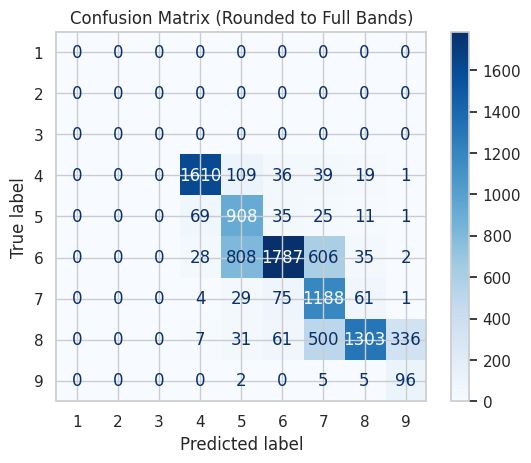

In [11]:

import os
import re
import numpy as np
import pandas as pd
import torch
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import pearsonr, spearmanr
from src.model.transformer import IELTSTransformerWithFeatures
from torch.utils.data import Dataset, DataLoader

# CONFIGURATION
project_root = "/home/mastermind/ielts_pred"
data_path = "data/predictions_hf_converted.csv"  
model_checkpoint = os.path.join(project_root, "src/model/ielts_fasttext_aug_model.pt")
spm_model_path = os.path.join(project_root, "tokenizer/spm.model")
features_mean_path = os.path.join(project_root, "features_mean_fasttext.npy")
features_std_path = os.path.join(project_root, "features_std_fasttext.npy")

MAX_SEQ_LEN = 200
EMBEDDING_DIM = 300
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA
df = pd.read_csv(data_path)
assert 'Essay' in df.columns and 'Overall' in df.columns

def extract_linguistic_features(essay):
    words = essay.split()
    sentences = re.split(r'[.!?]+', essay)
    sentences = [s.strip() for s in sentences if s.strip()]
    features = [
        len(words),
        len(sentences) if sentences else 1,
        len(words) / max(len(sentences), 1),
        len(set(w.lower() for w in words)) / max(len(words), 1),
        len(essay),
        sum(1 for c in essay if c.isupper()) / max(len(essay), 1),
        essay.count(',') / max(len(words), 1),
        essay.count('.') / max(len(sentences), 1),
        sum(len(w) for w in words) / max(len(words), 1),
        sum(1 for w in words if w.lower() in {
            'however', 'moreover', 'furthermore', 'therefore', 'consequently',
            'nevertheless', 'additionally', 'specifically', 'particularly', 'especially'
        }) / max(len(words), 1)
    ]
    return np.array(features, dtype='float32')

sp = spm.SentencePieceProcessor(model_file=spm_model_path)
vocab_size = sp.get_piece_size()

def tokenize_essays(essays, max_len=MAX_SEQ_LEN):
    encoded, masks = [], []
    for e in essays:
        ids = sp.encode(e, out_type=int)[:max_len]
        mask = [1]*len(ids) + [0]*(max_len - len(ids))
        padded = ids + [0]*(max_len - len(ids))
        encoded.append(padded)
        masks.append(mask)
    return torch.tensor(encoded), torch.tensor(masks)

X_tok, X_mask = tokenize_essays(df['Essay'].values)
features = np.array([extract_linguistic_features(e) for e in df['Essay'].values])
mean = np.load(features_mean_path)
std = np.load(features_std_path)
features = (features - mean) / std
X_feat = torch.tensor(features, dtype=torch.float32)
y_true = df['Overall'].values

# MODEL LOADING
checkpoint = torch.load(model_checkpoint, map_location=device)
model = IELTSTransformerWithFeatures(
    vocab_size=checkpoint['vocab_size'],
    d_model=checkpoint['embedding_dim'],
    nhead=6,
    num_layers=4,
    max_len=MAX_SEQ_LEN,
    dropout=0.25
)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


class IELTSDataset(Dataset):
    def __init__(self, essays, features, scores):
        self.essays = essays
        self.features = features
        self.scores = scores

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        e = self.essays[idx]
        f = self.features[idx]
        return e, f, self.scores[idx]

def collate_batch(batch):
    essays, feats, scores = zip(*batch)
    X_tok, X_mask = tokenize_essays(essays)
    X_feat = torch.tensor(np.array(feats), dtype=torch.float32)
    y = torch.tensor(scores, dtype=torch.float32)
    return X_tok, X_mask, X_feat, y

dataset = IELTSDataset(df["Essay"].values, features, y_true)
loader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)

all_preds = []

model.eval()
with torch.no_grad():
    for X_tok, X_mask, X_feat, y in loader:
        X_tok = X_tok.to(device)
        X_mask = X_mask.to(device)
        X_feat = X_feat.to(device)

        pred_scaled = model(X_tok, X_feat, X_mask).squeeze()
        pred = (pred_scaled.cpu().numpy() * 9.0).clip(1, 9)

        all_preds.extend(pred)

y_pred = np.array(all_preds)

# METRICS
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
pearson_r, _ = pearsonr(y_true, y_pred)
spearman_rho, _ = spearmanr(y_true, y_pred)

print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Pearson r: {pearson_r:.3f}")
print(f"Spearman rho: {spearman_rho:.3f}")

# VISUALIZATIONS
sns.set(style="whitegrid")

# Histogram
plt.figure(figsize=(8, 4))
plt.hist(y_true, bins=np.arange(1,10)-0.5, alpha=0.6, label='Actual')
plt.hist(y_pred, bins=np.arange(1,10)-0.5, alpha=0.6, label='Predicted')
plt.xlabel("IELTS Band Score")
plt.ylabel("Count")
plt.title("Distribution of Actual vs Predicted Scores")
plt.legend()
plt.show()

# Scatter
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([1, 9], [1, 9], 'r--')
plt.xlabel("Actual Band")
plt.ylabel("Predicted Band")
plt.title("Actual vs Predicted IELTS Bands")
plt.show()

# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(7, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Band")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Plot")
plt.show()

# Confusion Matrix (rounded)
y_true_rounded = np.rint(y_true).astype(int)
y_pred_rounded = np.rint(y_pred).astype(int)
cm = confusion_matrix(y_true_rounded, y_pred_rounded, labels=np.arange(1,10))
ConfusionMatrixDisplay(cm, display_labels=np.arange(1,10)).plot(cmap='Blues')
plt.title("Confusion Matrix (Rounded to Full Bands)")
plt.show()
